In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import shap

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
users = pd.read_csv('', 
                   encoding = "ISO-8859-1")
print(f'There are {users.duplicated().sum()} duplicated entries.')
print(users.shape)
users.head()

There are 0 duplicated entries.
(12000, 10)


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
users.describe()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3383.761968
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000


In [4]:
users.dtypes

object_id                       int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
dtype: object

In [5]:
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'],unit='s')

In [6]:
users['creation_time'] = pd.to_datetime(users['creation_time'])

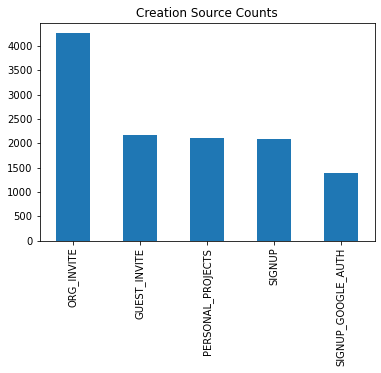

In [7]:
users['creation_source'].value_counts().plot(kind='bar')
plt.title('Creation Source Counts')
plt.show()

In [8]:
print(f'The earliest account creation is: {users["creation_time"].min()}')
print(f'The most recent account creation is:{users["creation_time"].max()}\n')

print(f'The earliest date for last login is: {users["last_session_creation_time"].min()}')
print(f'The most recent date for last login is: {users["last_session_creation_time"].max()}')

The earliest account creation is: 2012-05-31 00:43:27
The most recent account creation is:2014-05-30 23:59:19

The earliest date for last login is: 2012-05-31 08:20:06
The most recent date for last login is: 2014-06-06 14:58:50


In [9]:
engagement = pd.read_csv('', 
                   encoding = "ISO-8859-1")
print(f'There are {engagement.duplicated().sum()} duplicated entries.')
print(engagement.shape)
engagement.head()

There are 0 duplicated entries.
(207917, 3)


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [10]:
#Creating filter to get user ids with three or more logins

login_filter = engagement.groupby('user_id')['user_id'].filter(lambda x: len(x) >= 3)
adopted_engagement = engagement[engagement['user_id'].isin(login_filter)]

In [11]:
#Creating a new column that contains the date for one week from each login timestamp

week = []
adopted_engagement['time_stamp'] = pd.to_datetime(adopted_engagement['time_stamp'])
for timestamp in adopted_engagement['time_stamp']:
    week.append(timestamp + datetime.timedelta(days=7))
    
adopted_engagement['week'] = week
adopted_engagement.head()



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,time_stamp,user_id,visited,week
1,2013-11-15 03:45:04,2,1,2013-11-22 03:45:04
2,2013-11-29 03:45:04,2,1,2013-12-06 03:45:04
3,2013-12-09 03:45:04,2,1,2013-12-16 03:45:04
4,2013-12-25 03:45:04,2,1,2014-01-01 03:45:04
5,2013-12-31 03:45:04,2,1,2014-01-07 03:45:04


In [12]:
#Resetting the index for the new engagement dataframe 

adopted_engagement = adopted_engagement.reset_index()
adopted_engagement = adopted_engagement.drop(columns=['index'])
adopted_engagement.head()

,time_stamp,user_id,visited,week
0,2013-11-15 03:45:04,2,1,2013-11-22 03:45:04
1,2013-11-29 03:45:04,2,1,2013-12-06 03:45:04
2,2013-12-09 03:45:04,2,1,2013-12-16 03:45:04
3,2013-12-25 03:45:04,2,1,2014-01-01 03:45:04
4,2013-12-31 03:45:04,2,1,2014-01-07 03:45:04


In [13]:
#Creating a new column for adopted users
#The loop checks that the next two timestamps for one user's login timestamp are within one week of each other

adopted_user = []

for index in range(0,201000):
    if adopted_engagement['user_id'][index] == adopted_engagement['user_id'][index+1]:
        if (adopted_engagement['time_stamp'][index+1] < adopted_engagement['week'][index]) & (adopted_engagement['time_stamp'][index+2] < adopted_engagement['week'][index]):
            adopted_user.append('yes')
        else:
            adopted_user.append('no')
    else:
        adopted_user.append('diff_user')
        
adopted_user.extend(['outside_idx','outside_idx'])
adopted_engagement['adopted_user'] = adopted_user 
adopted_engagement.head()

,time_stamp,user_id,visited,week,adopted_user
0,2013-11-15 03:45:04,2,1,2013-11-22 03:45:04,no
1,2013-11-29 03:45:04,2,1,2013-12-06 03:45:04,no
2,2013-12-09 03:45:04,2,1,2013-12-16 03:45:04,no
3,2013-12-25 03:45:04,2,1,2014-01-01 03:45:04,no
4,2013-12-31 03:45:04,2,1,2014-01-07 03:45:04,no


In [14]:
#Creating an adopted users column for the users dataframe

confirmed = adopted_engagement.query('adopted_user == "yes"')

adopted = list(confirmed['user_id'])
confirmed_adopted = []

for user in users['object_id']:
    if user in adopted:
        confirmed_adopted.append('1')
    else:
        confirmed_adopted.append('0')
        
users['confirmed_adopted'] = confirmed_adopted
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,confirmed_adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0


In [15]:
#FEATURE ENGINEERING
#Making a new column for if a user was invited

invited = []
all_users = list(users['object_id'])

for user in users['invited_by_user_id']:
    if user in all_users:
        invited.append(1)
    else:
        invited.append(0)
        
users['invited'] = invited
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,confirmed_adopted,invited
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,1


In [16]:
#FEATURE ENGINEERING
#Making a new column for if a user invited someone else

inviter = []
inviters = list(users['object_id'])

for user in users['invited_by_user_id']:
    if user in inviters:
        inviter.append(1)
    else:
        inviter.append(0)

users['inviter'] = inviter
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,confirmed_adopted,invited,inviter
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,1,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,1,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,1,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,1,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,1,1


In [17]:
#FEATURE ENGINEERING
#Making a new column for the current age of a user's account, or the time between account creation and last login

account_age = []

for index in users.index:
    try:
        account_age.append((users['last_session_creation_time'][index] - users['creation_time'][index]).days)
    except:
        account_age.append(0)
users['account_age'] = account_age
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,confirmed_adopted,invited,inviter,account_age
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,1,1,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,1,1,136.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,1,1,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,1,1,1.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,1,1,5.0


In [18]:
users['account_age'] = users['account_age'].fillna(0)
users.isnull().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
confirmed_adopted                0
invited                          0
inviter                          0
account_age                      0
dtype: int64

In [19]:
#Preparing features for modeling

variables = pd.get_dummies(users['creation_source'])
users2 = users.drop(['creation_source','invited_by_user_id', 'last_session_creation_time', 
                         'email', 'name', 'object_id', 'creation_time'],axis=1)
df = pd.concat([users2,variables], axis=1)
df.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,confirmed_adopted,invited,inviter,account_age,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
0,1,0,11,0,1,1,0.0,1,0,0,0,0
1,0,0,1,1,1,1,136.0,0,1,0,0,0
2,0,0,94,0,1,1,0.0,0,1,0,0,0
3,0,0,1,0,1,1,1.0,1,0,0,0,0
4,0,0,193,0,1,1,5.0,1,0,0,0,0


In [20]:
x = df.drop(['confirmed_adopted'],axis=1)
y = df['confirmed_adopted']

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.80, random_state=1)

In [21]:
#Testing four tree-based models for their average accuracy and balanced accuracy

models = []

models.append(('CART', DecisionTreeClassifier()))
models.append(('XGB', GradientBoostingClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('BRF', BalancedRandomForestClassifier()))

accuracy = []
balanced_accuracy = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    scores = cross_validate(model, x_train, y_train, cv=kfold, 
                            scoring=['accuracy','balanced_accuracy'],return_train_score=True)
    accuracy.append(scores['test_accuracy'])
    balanced_accuracy.append(scores['test_balanced_accuracy'])
    names.append(name)
    msg = "%s: Average Accuracy (%f); Average Balanced Accuracy (%f)" % (name, scores['test_accuracy'].mean(),scores['test_balanced_accuracy'].mean())
    print(msg)

CART: Average Accuracy (0.952187); Average Balanced Accuracy (0.910275)
XGB: Average Accuracy (0.963542); Average Balanced Accuracy (0.918706)
RF: Average Accuracy (0.962292); Average Balanced Accuracy (0.918247)
BRF: Average Accuracy (0.943021); Average Balanced Accuracy (0.955702)


              precision    recall  f1-score   support

           0       1.00      0.92      0.96      2032
           1       0.70      0.98      0.82       368

    accuracy                           0.93      2400
   macro avg       0.85      0.95      0.89      2400
weighted avg       0.95      0.93      0.94      2400



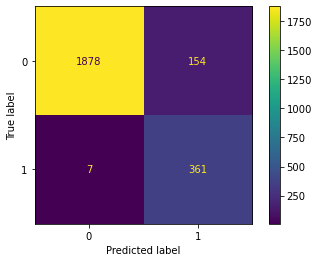

In [22]:
brf = BalancedRandomForestClassifier(random_state=1)

brf.fit(x_train,y_train)
y_pred = brf.predict(x_test)

cm = confusion_matrix(y_test,y_pred)

print(classification_report(y_test,y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=brf.classes_)
disp.plot()

plt.show()

[0.00404335 0.00324705 0.06590721 0.00095828 0.00102988 0.91156485
 0.00201144 0.00145811 0.00629962 0.00164361 0.00183661]


<BarContainer object of 11 artists>

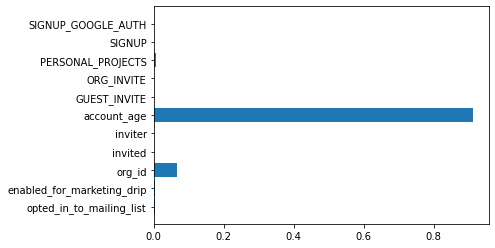

In [23]:
print(brf.feature_importances_)
plt.barh(x_test.columns, brf.feature_importances_)

In [24]:
#Generating shap values for the model

explainer = shap.explainers.Tree(brf)
shap_values = explainer.shap_values(x_test)
shap_test = explainer(x_test)

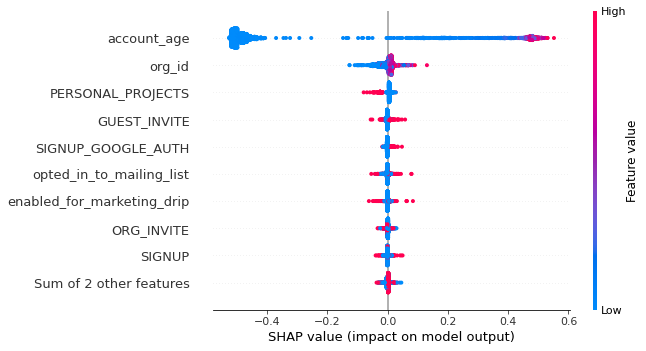

In [25]:
shap.plots.beeswarm(shap_test[:,:,1])

In [26]:
#Separating individual predictions based on if they were correct or not 

test_df = pd.concat([x_test,y_test],axis=1)
test_df['probability_adopting'] = brf.predict_proba(x_test)[:,1]
test_df['test_set_idx'] = np.arange(len(test_df))

false_negatives = test_df.query('confirmed_adopted == "1" & probability_adopting < 0.50')
true_negatives = test_df.query('confirmed_adopted == "0" & probability_adopting < 0.50')
false_positives = test_df.query('confirmed_adopted == "0" & probability_adopting > 0.50')
true_positives = test_df.query('confirmed_adopted == "1" & probability_adopting > 0.50')

In [27]:
def shap_explanation(df, index,label=1):
    """This function creates a waterfall plot for a given row in a specified dataframe."""
    idx = int(df.iloc[index]['test_set_idx'])
    shap.plots.waterfall(shap_test[:,:,label][idx],max_display=11)

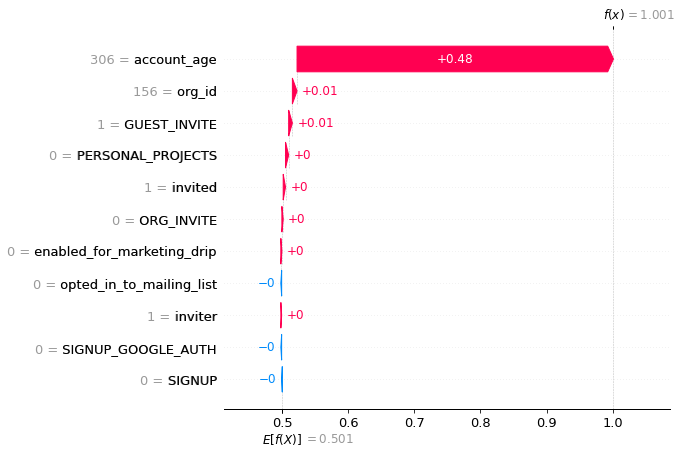

In [28]:
shap_explanation(df=true_positives,index=157)

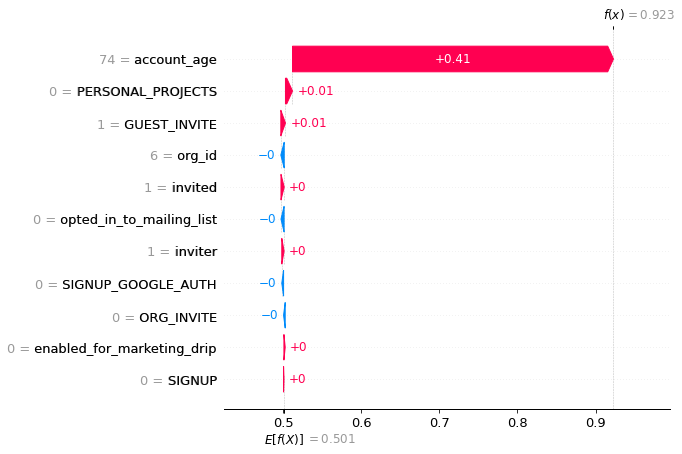

In [29]:
shap_explanation(df=true_positives,index=15)

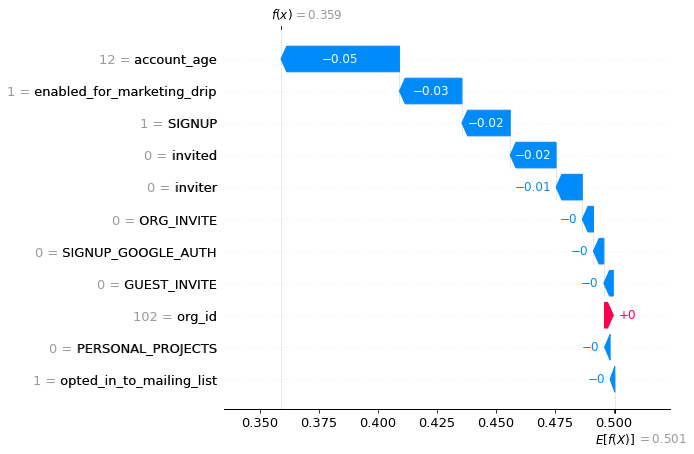

In [31]:
shap_explanation(df=false_negatives,index=5)

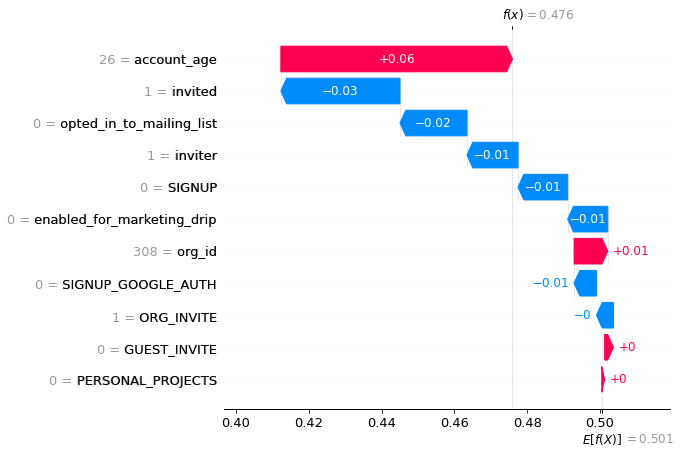

In [35]:
shap_explanation(df=false_negatives,index=3)